In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import re
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from xgboost import XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier



df_train = pd.read_csv('./input/train.csv', index_col='PassengerId')
df_test = pd.read_csv('./input/test.csv', index_col='PassengerId')


df_complete = pd.DataFrame(df_train.drop(['Survived'], axis=1)).append(df_test)

df_test['LastName']  = df_test.Name.str.split(',').str[0]
df_train['LastName']  = df_train.Name.str.split(',').str[0]
df_complete['LastName']  = df_complete.Name.str.split(',').str[0]

def ticket_group(x):
    tg_l1 = { "STONO", "STONO2", "SOTONOQ", "SOTONO2"}
    tg_l2 = {"SCAH", "SCAH"}
    tg_l3 = {"AS", "A4", "A5"}
    if any(x in s for s in tg_l1):
        return "SOTONO"
    elif any(x in s for s in tg_l2): 
        return "SCA"
    elif any(x in s for s in tg_l3):
        return "A"
    elif x == "PPP":
        return "PP"
    elif x == "CASOTON":
        return "CA"
    elif x == "SOP":
        return "SOPP"   
    else:
        return ""

def extract_title(r):
    if re.search('[mMrR]{2}\.', r.Name):
        return 'MR'
    if re.search('[mMiIsSsS]{4}\.', r.Name):
        return 'MISS'
    if re.search('[mMrRsS]{3}\.', r.Name):
        return 'MRS'
    if re.search('[mMaAsStTeErR]{5}\.', r.Name):
        return 'MASTER'
    if re.search('[dDrR]{2}\.', r.Name):
        return 'DR'
    if re.search('[rReEvV]{3}\.', r.Name):
        return 'REV'
    return 'OTHER'

df_train['Title'] = df_train.apply(lambda r : extract_title(r) , axis = 1)
df_complete['Title'] = df_complete.apply(lambda r : extract_title(r) , axis = 1)
df_test['Title'] = df_test.apply(lambda r : extract_title(r) , axis = 1)

def extract_ticket_info_group(ticket):
    regex = re.search('(.+) ([0-9]{1,7})$', ticket)
    if regex is not None:
        # regexGroup = re.findall('[A-Za-z0-9]+', regex.group(1))[0]
        # return regexGroup
        x = re.sub('(\\.)|(\\/)','', regex.group(1))
        return ticket_group(x)
    return np.nan

def extract_ticket_number(ticket):
    regex = re.search('(.+) ([0-9]{1,7})$', ticket)
    if regex is not None:
        return regex.group(2)
    return ticket

def bucket_fare(x):
    if x <= 25:
        return 0
    elif x <= 45:
        return 1
    elif x <= 65:
        return 2
    elif x <= 100:
        return 3
    elif x <= 200:
        return 4
    else:
        return 5

def bucket_age(x):
    if x <= 12:
        return 0
    elif x <= 8:
        return 1
    elif x <= 30:
        return 2
    elif x <= 40:
        return 3
    elif x <= 50:
        return 4
    else:
        return 5



df_train['ticket_group'] = df_train.apply(lambda r : extract_ticket_info_group(r.Ticket) , axis = 1)
df_complete['ticket_group'] = df_complete.apply(lambda r : extract_ticket_info_group(r.Ticket) , axis = 1)
df_test['ticket_group'] = df_test.apply(lambda r : extract_ticket_info_group(r.Ticket) , axis = 1)

df_train['ticket_number'] = df_train.apply(lambda r : extract_ticket_number(r.Ticket) , axis = 1)
df_complete['ticket_number'] = df_complete.apply(lambda r : extract_ticket_number(r.Ticket) , axis = 1)
df_test['ticket_number'] = df_test.apply(lambda r : extract_ticket_number(r.Ticket) , axis = 1)

df_train['ticket_number'] = df_train.apply(lambda row : 0 if row.ticket_number == 'LINE' else pd.to_numeric( row.ticket_number) , axis=1) 
df_complete['ticket_number'] = df_complete.apply(lambda row : 0 if row.ticket_number == 'LINE' else pd.to_numeric( row.ticket_number) , axis=1) 
df_test['ticket_number'] = df_test.apply(lambda row : 0 if row.ticket_number == 'LINE' else pd.to_numeric( row.ticket_number) , axis=1) 

df_train['fare_bucket'] = df_train.apply(lambda r : None if pd.isnull(r.Fare) else bucket_fare(r.Fare) , axis = 1)
df_complete['fare_bucket'] = df_complete.apply(lambda r :None if pd.isnull(r.Fare) else bucket_fare(r.Fare) , axis = 1)
df_test['fare_bucket'] = df_test.apply(lambda r :None if pd.isnull(r.Fare) else bucket_fare(r.Fare) , axis = 1)

df_train['age_bucket'] = df_train.apply(lambda r : None if pd.isnull(r.Age) else bucket_age(r.Age) , axis = 1)
df_complete['age_bucket'] = df_complete.apply(lambda r :None if pd.isnull(r.Age) else bucket_age(r.Age) , axis = 1)
df_test['age_bucket'] = df_test.apply(lambda r :None if pd.isnull(r.Age) else bucket_age(r.Age) , axis = 1)

# Configure label encoders
le_sex = preprocessing.LabelEncoder()
le_sex.fit(df_complete['Sex'])

le_ticket_group = preprocessing.LabelEncoder()
le_ticket_group.fit(df_complete['ticket_group'].dropna())

le_section = preprocessing.LabelEncoder()
section = df_complete.apply(lambda row : None if pd.isnull(row.Cabin) else row.Cabin[0] , axis=1).dropna().unique()
le_section.fit(section) 

le_embarked = preprocessing.LabelEncoder()
embarked = df_complete.apply(lambda row : None if pd.isnull(row.Embarked) else row.Embarked , axis=1).dropna().unique()
le_embarked.fit(embarked) 

le_lastname = preprocessing.LabelEncoder()
le_lastname.fit(df_complete['LastName']) 

le_title = preprocessing.LabelEncoder()
le_title.fit(df_complete['Title']) 


survialByTitle = df_train[['Title','Survived']].where(df_train.Survived==True).groupby(['Title']).agg(['count']) / df_train[['Title','Survived']].where(df_train.Survived==False).groupby(['Title']).agg(['count'])    

personsPerLastNameForSInge = df_complete.LastName.groupby(df_complete.LastName).count().to_dict()
personsPerLastName = df_train.LastName.groupby(df_train.LastName).count().to_dict()

family = df_train.groupby(df_train.LastName).Survived  
d = family.apply(list)

# Estimate age
clf_age = LinearSVC(random_state=42, tol=1e-5, max_iter=10000)
df_age = df_complete[['Pclass', 'Title', 'SibSp', 'age_bucket']].dropna()

df_age['Title'] = df_age.apply(lambda row : pd.NA if pd.isnull(row.Title) else le_title.transform([row.Title])[0], axis = 1)
sc_age = StandardScaler()
clf_age.fit(sc_age.fit_transform( df_age[['Pclass', 'Title', 'SibSp']]), df_age['age_bucket'])

# Estimate missing sections
lr_section = LinearRegression()
df_section = df_complete[['Pclass', 'fare_bucket','Embarked', 'Cabin', 'age_bucket']].dropna()
df_section['Section'] = df_section.apply(lambda row : pd.NA if pd.isnull(row.Cabin) else le_section.transform([row.Cabin[0]])[0] , axis=1)
df_section['Embarked'] = df_section.apply(lambda row : pd.NA if pd.isnull(row.Embarked) else le_embarked.transform([row.Embarked])[0] , axis=1)

clf_section =  LinearSVC(random_state=0, tol=1e-5)
sc_section = StandardScaler()
clf_section.fit(sc_section.fit_transform(df_section.dropna()[['Pclass', 'fare_bucket', 'age_bucket']]), df_section['Section'])

# Estimate missing Fares
clf_fare = LinearSVC(random_state=42, tol=1e-5)
fare_df = df_complete[['Pclass', 'Embarked', 'fare_bucket', 'Cabin', 'Parch']].dropna()
fare_df['Section'] = fare_df.apply(lambda row : pd.NA if pd.isnull(row.Cabin) else le_section.transform([row.Cabin[0]])[0] , axis=1) 
fare_df['Embarked'] = fare_df.apply(lambda row : pd.NA if pd.isnull(row.Embarked) else le_embarked.transform([row.Embarked])[0] , axis=1)
sc_fare = StandardScaler()
clf_fare.fit(sc_fare.fit_transform(fare_df[['Pclass', 'Parch','Embarked']]), fare_df['fare_bucket'])


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=1e-05,
          verbose=0)

In [2]:
m = {}
for k, v in d.to_dict().items():
    m[k] = sum(v) / personsPerLastNameForSInge[k]


df_test['SurvivalRateByLastName'] =df_test.apply(lambda r :  m[r['LastName']] if r['LastName'] in m else 0 , axis =1)
df_train['SurvivalRateByLastName'] = df_train.apply(lambda r :  m[r['LastName']] if r['LastName'] in m else 0 , axis =1)
df_complete['SurvivalRateByLastName'] = df_complete.apply(lambda r :  m[r['LastName']] if r['LastName'] in m else 0 , axis =1)

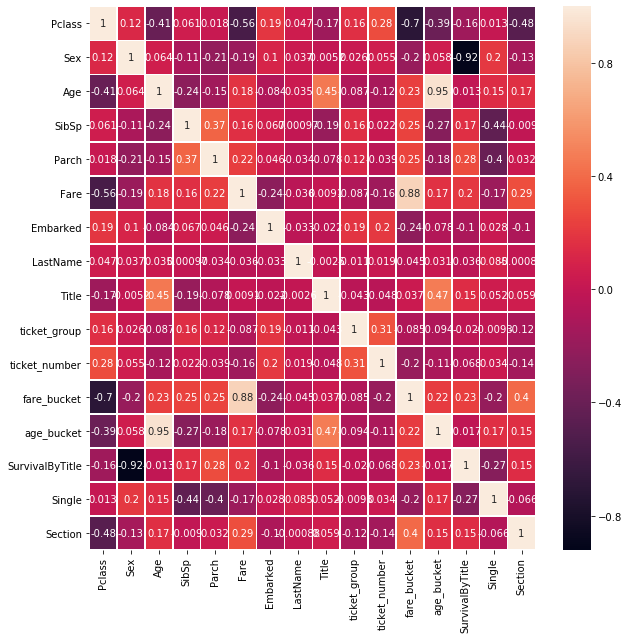

In [354]:
def prepare_correlation(df):
    df['Embarked'] = df['Embarked'].fillna(method='ffill')
    df['Sex'] = le_sex.transform(df.Sex)
    df['Embarked'] = le_embarked.transform(df.Embarked)
    df['SurvivalByTitle'] = df.apply(lambda row : survialByTitle.loc[row.Title,:][0] , axis=1)
    df['SurvivalByTitle'] = df.apply(lambda row: 0 if pd.isna(row.SurvivalByTitle) else row.SurvivalByTitle, axis =1)
    df['Title'] = le_title.transform(df.Title)
    df['Single'] = df.apply(lambda row : 1 if personsPerLastNameForSInge[row.LastName] == 1 else 0, axis=1)
    df['LastName'] =  le_lastname.transform(df.LastName)
    df['Section'] = df.apply(lambda row : 0 if pd.isnull(row.Cabin) else le_section.transform([row.Cabin[0]])[0] , axis=1)
    df['ticket_group'] = df.apply(lambda row : le_ticket_group.transform([''])[0] if pd.isna(row.ticket_group) else le_ticket_group.transform([row.ticket_group])[0] , axis=1) 
    return df
df_corr = prepare_correlation(df_complete)
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_corr.corr(), annot=True,linewidths=.5, ax=ax)

In [2]:
def prepare(df):
    df['Embarked'] = df['Embarked'].fillna(method='ffill')
    df['Sex'] = le_sex.transform(df.Sex)
    df['Embarked'] = le_embarked.transform(df.Embarked)

    df['SurvivalByTitle'] = df.apply(lambda row : survialByTitle.loc[row.Title,:][0] , axis=1)
    df['SurvivalByTitle'] = df.apply(lambda row: 0 if pd.isna(row.SurvivalByTitle) else row.SurvivalByTitle, axis =1)
    df['Title'] = le_title.transform(df.Title)
    # df['Age'] = df.apply(lambda row : lr_age.predict(sc_age.transform([[row.Pclass, row.Title, row.SibSp]]))[0] if pd.isna(row.Age) else row.Age, axis=1)
    df['age_bucket'] = df.apply(lambda row : clf_age.predict([[row.Pclass, row.Title, row.SibSp]])[0] if pd.isna(row.age_bucket) else row.age_bucket, axis=1)
    df['Single'] = df.apply(lambda row : 1 if personsPerLastNameForSInge[row.LastName] == 1 else 0, axis=1)
    df['PersonsInFamliy'] = df.apply(lambda row : personsPerLastNameForSInge[row.LastName], axis=1)
    df['LastName'] =  le_lastname.transform(df.LastName)
    # df['Fare'] = df.apply(lambda row : lr_fare.predict(sc_fare.transform([[row.Pclass, row.Parch, row.Embarked]]))[0] if pd.isna(row.Fare) else row.Fare , axis=1)
    df['fare_bucket'] = df.apply(lambda row : clf_fare.predict(sc_fare.transform([[row.Pclass, row.Parch, row.Embarked]]))[0] if pd.isna(row.fare_bucket) else row.fare_bucket, axis=1)
    df['Section'] = df.apply(lambda row : clf_section.predict(sc_section.transform([[row.Pclass,  row.fare_bucket,  row.age_bucket]]))[0] if pd.isnull(row.Cabin) else le_section.transform([row.Cabin[0]])[0] , axis=1)
    df['ticket_group'] = df.apply(lambda row : le_ticket_group.transform([''])[0] if pd.isna(row.ticket_group) else le_ticket_group.transform([row.ticket_group])[0] , axis=1) 
    return df

df_train = prepare(df_train)
df_test = prepare(df_test)
df_complete = prepare(df_complete)    
target = df_train['Survived']

In [223]:
import plotly.express as px
fig = px.scatter(x=df_train['Survived'], y=df_train['Age'])
fig.show()

In [158]:
import plotly.express as px
fig = px.scatter(x=df_complete['Fare'], y=df_complete['Age'])
fig.show()

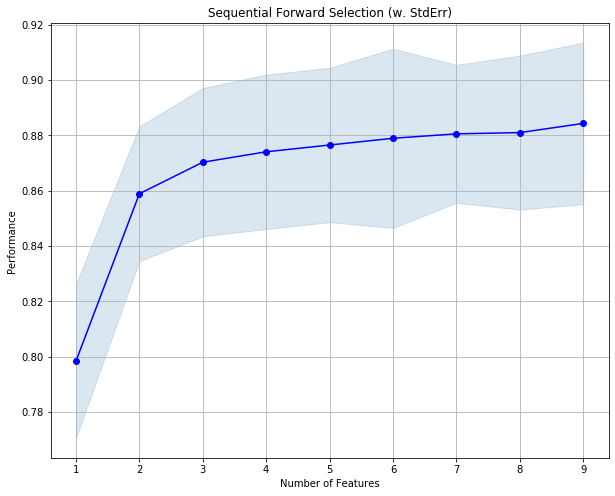

['Pclass', 'Sex', 'SibSp', 'Section', 'LastName', 'Title', 'ticket_number', 'fare_bucket', 'SurvivalByTitle']


In [3]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

scaler_sf = StandardScaler()

X_selection = df_train[['Pclass', 'Sex', 'SibSp','Parch', 'Section', 'Single',  'LastName', 'Title', 'ticket_group', 'ticket_number',  'fare_bucket', 'age_bucket', 'SurvivalByTitle', 'PersonsInFamliy']]

xgbc_fs = XGBClassifier()
sfs = SFS(estimator=xgbc_fs,
           k_features=9,
          cv=5,
           scoring='roc_auc',
           forward=True)

sfs.fit(X_selection, target)

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(10, 8))
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()
selected_features = list(sfs.k_feature_names_)
print(selected_features)

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def create_model():
	# create model
	model = Sequential()
	model.add(Dense(60, input_dim=9, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

scaler = StandardScaler()
scaler.fit(df_complete[selected_features])

X_train, X_test, y_train, y_test = train_test_split(scaler.transform(df_train[selected_features]), target, test_size=0.20, random_state=42)

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Cross_val_score: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_train, y_train)
k_train_predicted = estimator.predict(X_train)
k_test_predicted = estimator.predict(X_test)
print(classification_report(y_train, k_train_predicted))
print(classification_report(y_test, k_test_predicted))
print("Accuracy: ", estimator.score(X_test, y_test))

Using TensorFlow backend.
Cross_val_score: 81.46% (5.56%)
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       444
           1       0.90      0.72      0.80       268

    accuracy                           0.86       712
   macro avg       0.87      0.84      0.85       712
weighted avg       0.87      0.86      0.86       712

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.66      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179

Accuracy: 0.8044692873954773


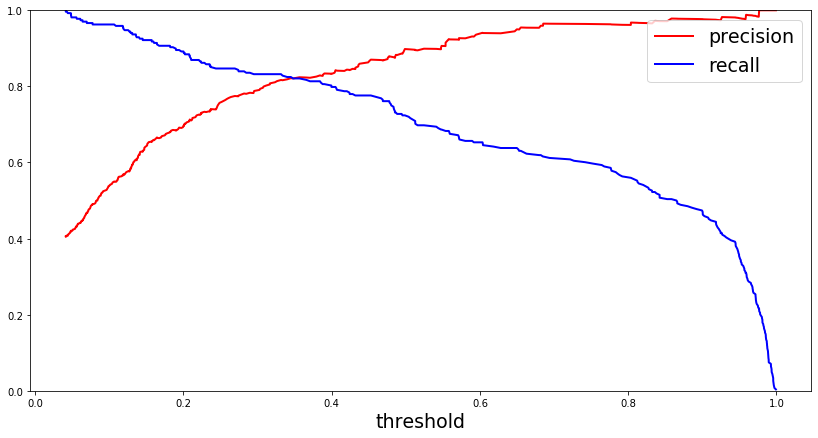

ROC-AUC-Score: 0.9201963157187038


In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
y_scores = estimator.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=2)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=2)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

r_a_score = roc_auc_score(y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)
# print(classification_report(y_train, k_train_predicted.reshape(1, -1)[0]))
# print(classification_report(y_test, k_test_predicted.reshape(1, -1)[0]))


In [41]:
submission = pd.DataFrame(df_test.index.values, columns=['PassengerId'])
submission_predictions = estimator.predict(scaler.transform(df_test[selected_features]))
submission['Survived'] = submission_predictions
submission.to_csv('submission.csv', index=False)

In [38]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_complete[selected_features])

X_train, X_test, y_train, y_test = train_test_split(scaler.transform(df_train[selected_features]), target, test_size=0.15, random_state=42)
# X_train = scaler.transform(X_train)

# X_test = scaler.transform(X_test)
eval_set = [(X_test, y_test)]
gbm = XGBRFClassifier(random_state=42, eval_metric="auc", eval_set=eval_set, num_round = 2)
# gbm = XGBClassifier()

params = {
      'n_estimators' :[2, 3,5,8,16,32,64,128],
      'learning_rate': [0.2, 0.1, 0.05],
      'max_depth' : [3,4,5,6, 8],
      'objective':['binary:logistic'],
      'seed': [1337],
      'min_child_weight': [7, 11, 15, 20],
      }

clf = GridSearchCV(gbm, params, n_jobs=5,
                   cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=7),
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(X_train, y_train)

predictions = clf.best_estimator_.predict(X_train)
predictions_test = clf.best_estimator_.predict(X_test)


print(classification_report(y_train, predictions))
print(classification_report(y_test, predictions_test))
print("Accuracy: ", clf.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 871 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 2495 tasks      | elapsed:   15.4s
[Parallel(n_jobs=5)]: Done 4752 tasks      | elapsed:   27.3s
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       471
           1       0.79      0.70      0.74       286

    accuracy                           0.82       757
   macro avg       0.81      0.79      0.80       757
weighted avg       0.81      0.82      0.81       757

              precision    recall  f1-score   support

           0       0.84      0.85      0.84        78
           1       0.78      0.77      0.77        56

    accuracy                           0.81       134
   macro avg       0.81      0.81      0.81       134
weighted avg   

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
y_scores = clf.best_estimator_.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=2)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=2)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

r_a_score = roc_auc_score(y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

NameError: name 'clf' is not defined

In [34]:

submission = pd.DataFrame(df_test.index.values, columns=['PassengerId'])
submission_predictions = clf.best_estimator_.predict(scaler.transform(df_test[selected_features]))
submission['Survived'] = submission_predictions
submission.to_csv('submission.csv', index=False)